## CricScore Workflow

In [7]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [ ]:
# Define State
class BatsmanState(TypedDict):
    runs: int
    balls: int
    fours: int
    sixes: int

    sr: float
    bpb: float
    bp: float
    summary: str

In [32]:
# Creating Nodes
def calculateSR(state: BatsmanState) -> dict:
    sr = (state['runs']/state['balls'])*100
    return {'sr': sr}

def calculateBPB(state: BatsmanState) -> dict:
    bpb = state['balls']/(state['fours'] + state['sixes'])
    return {'bpb': bpb}

def calculateBP(state: BatsmanState) -> dict:
    boundary_percent = (((state['fours'] * 4) + (state['sixes'] * 6))/state['runs'])*100
    return {'boundary_percent': boundary_percent}

def summary(state: BatsmanState) -> dict:
    summary = f"""Summary of Batsman in an Inning:
    Strike Rate - {state['sr']}
    Balls per boundary - {state['bpb']}
    Boundary percent - {state['boundary_percent']}
    """
    
    return {'summary': summary}

In [33]:
# Creating Graph
batsmanGraph = StateGraph(BatsmanState)

batsmanGraph.add_node('calculateSR', calculateSR)
batsmanGraph.add_node('calculateBPB', calculateBPB)
batsmanGraph.add_node('calculateBP', calculateBP)
batsmanGraph.add_node('summary', summary)

# edges

batsmanGraph.add_edge(START, 'calculateSR')
batsmanGraph.add_edge(START, 'calculateBPB')
batsmanGraph.add_edge(START, 'calculateBP')

batsmanGraph.add_edge('calculateSR', 'summary')
batsmanGraph.add_edge('calculateBPB', 'summary')
batsmanGraph.add_edge('calculateBP', 'summary')

batsmanGraph.add_edge('summary', END)

batsmanWorkflow = batsmanGraph.compile()

In [34]:
# Execting Workflow
intialState = {
    'runs': 100,
    'balls': 50,
    'fours': 6,
    'sixes': 4
}

finalState = batsmanWorkflow.invoke(intialState)
print(finalState['summary'])

Summary of Batsman in an Inning:
    Strike Rate - 200.0
    Balls per boundary - 5.0
    Boundary percent - 48.0
    


## UPSC Eassy Evaluator

In [108]:
title = "Artificial Intelligence: A Tool for Human Progress"
essay = """Artificial Intelligence (AI) has emerged as one of the most transformative technologies of the modern age. By enabling machines to perform tasks that require human intelligence, AI is reshaping economies, governance, and social interactions. Often termed the “new electricity,” AI has the potential to enhance human capabilities, but it also poses significant ethical and socio-economic challenges.

AI is increasingly being applied across sectors. In healthcare, AI aids in early diagnosis, medical imaging, and drug discovery. In agriculture, it supports precision farming, crop monitoring, and yield optimization, which is vital for food security in developing countries like India. In education, AI-driven platforms offer personalized learning experiences, helping address learning inequalities. AI also improves governance by enabling data-driven decision-making, efficient service delivery, and fraud detection in welfare schemes.

Despite these benefits, AI raises serious concerns. Automation threatens to displace jobs, particularly those involving routine tasks. While AI will create new opportunities, the transition may exacerbate inequality unless reskilling and upskilling are prioritized. Ethical issues such as algorithmic bias, lack of transparency, and privacy violations further complicate AI adoption. The use of AI in surveillance and autonomous weapons also raises questions about civil liberties and global security.

For India, AI represents both an opportunity and a responsibility. With a large talent pool and expanding digital infrastructure, India can leverage AI for inclusive growth. However, this requires indigenous innovation, robust regulatory frameworks, and adherence to ethical principles. The vision of “AI for All” must guide policy to ensure that technological advancement aligns with constitutional values of equity and justice.

In conclusion, Artificial Intelligence is a powerful tool whose impact depends on human choices. A human-centric approach—focusing on ethics, inclusivity, and accountability—can ensure that AI serves as an enabler of sustainable development rather than a source of social disruption."""

In [38]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
load_dotenv()

Gemini = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [39]:
from pydantic import BaseModel, Field

class EvaluationSchema(BaseModel):
    feedback: str = Field(description="Detailed feedback for essay.")
    score: int = Field(description="Score out of 10.", ge=0, le=10)

structuredGemini = Gemini.with_structured_output(EvaluationSchema)

In [40]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    template="Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}",
    input_variables=['essay']
)

chain = prompt | structuredGemini

feedback = chain.invoke({'essay': essay})

In [41]:
feedback

EvaluationSchema(feedback="The essay demonstrates excellent language quality. It is well-structured, with a clear introduction, well-developed body paragraphs, and a concise conclusion. The vocabulary used is appropriate and sophisticated, enhancing the formal tone of the discussion without being overly jargonistic. Grammatical accuracy is consistently high, and sentence structures are varied, contributing to a smooth and engaging reading experience. The arguments are presented clearly and logically, effectively covering both the benefits and challenges of AI, with a thoughtful focus on India's context. There are no significant errors in syntax, punctuation, or word choice, making it a very strong piece in terms of linguistic execution.", score=8)

In [98]:
from typing_extensions import TypedDict, Annotated
import operator

class EssayState(TypedDict):
    # Read-only, must be preserved across all branches
    essay: str

    # Parallel outputs
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str

    # Reduce fields
    individual_scores: Annotated[list[int], operator.add]

    # Final node outputs
    overall_feedback: str
    avg_score: str


In [125]:
from langchain_core.output_parsers import StrOutputParser
# Creating Nodes
def evaluatingLanguage(state: EssayState) -> dict:
    text = state['essay']
    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {text}"
    output = structuredGemini.invoke(prompt)
    return {'language_feedback':output.feedback, 'individual_scores': [output.score]}

def evaluatingAnalysis(state: EssayState) -> dict:
    text = state['essay']
    prompt = f"Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {text}"
    output = structuredGemini.invoke(prompt)
    return {'analysis_feedback':output.feedback, 'individual_scores': [output.score]}

def evaluatingThought(state: EssayState) -> dict:
    text = state['essay']
    prompt = f"Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {text}"
    output = structuredGemini.invoke(prompt)
    return {'clarity_feedback':output.feedback, 'individual_scores': [output.score]}


def finalEvaluation(state: EssayState) -> dict:
    prompt = f"Based on the following feedback, create a summarized feedback \n language feedback: {state['language_feedback']} \n depth of analysis feedback: {state['analysis_feedback']} \n clarity of thought {state['clarity_feedback']}"
    overall_feedback = Gemini.invoke(prompt).content
    avg_score = sum(state['individual_scores']) / len(state['individual_scores'])

    return {'overall_feedback': overall_feedback, 'avg_score':avg_score}


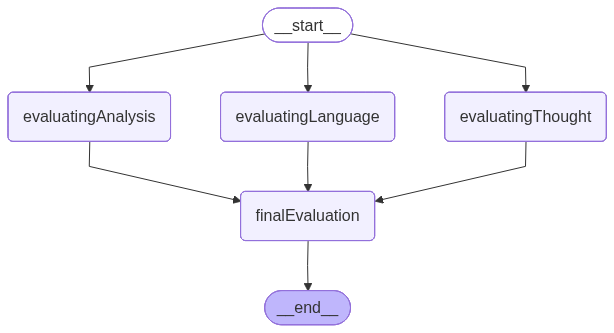

In [126]:
# Creating Graph
essayGraph = StateGraph(EssayState)

# Adding Nodes
essayGraph.add_node("evaluatingLanguage", evaluatingLanguage)
essayGraph.add_node("evaluatingAnalysis", evaluatingAnalysis)
essayGraph.add_node("evaluatingThought", evaluatingThought)
essayGraph.add_node("finalEvaluation", finalEvaluation)

# Connecting Edges
essayGraph.add_edge(START, "evaluatingLanguage")
essayGraph.add_edge(START, "evaluatingAnalysis")
essayGraph.add_edge(START, "evaluatingThought")

essayGraph.add_edge("evaluatingLanguage", "finalEvaluation")
essayGraph.add_edge("evaluatingAnalysis", "finalEvaluation")
essayGraph.add_edge("evaluatingThought", "finalEvaluation")

essayGraph.add_edge("finalEvaluation", END)

# Graph Compiling
essayWorkflow = essayGraph.compile()
essayWorkflow

In [127]:
final = essayWorkflow.invoke({'essay': essay})
final

{'essay': 'Artificial Intelligence (AI) has emerged as one of the most transformative technologies of the modern age. By enabling machines to perform tasks that require human intelligence, AI is reshaping economies, governance, and social interactions. Often termed the “new electricity,” AI has the potential to enhance human capabilities, but it also poses significant ethical and socio-economic challenges.\n\nAI is increasingly being applied across sectors. In healthcare, AI aids in early diagnosis, medical imaging, and drug discovery. In agriculture, it supports precision farming, crop monitoring, and yield optimization, which is vital for food security in developing countries like India. In education, AI-driven platforms offer personalized learning experiences, helping address learning inequalities. AI also improves governance by enabling data-driven decision-making, efficient service delivery, and fraud detection in welfare schemes.\n\nDespite these benefits, AI raises serious conce